In [2]:
'''this is made to analyse missing data patterns across all datasets to inform preprocessing
decisions for the clustering analysis'''

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.load import load_nhanes_data, get_key_variables
#set visualisation style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Imports successful")

Imports successful


In [3]:
# load all datasets
data = load_nhanes_data()

#get key variables for analysis
key_vars = get_key_variables()

print("\n" + "="*80)
print("DATASETS LOADED")
print("="*80)
for name, df in data.items():
    print(f"{name:20s}: {df.shape[0]:>6,} rows × {df.shape[1]:>3} columns")

Loading NHANES data files...
Looking for GLU_L.xpt in C:\Users\cherr\metabolic-phenotypes-pre-diabetes\data\raw\GLU_L.xpt
glucose         |  3,996 rows ×   4 columns | GLU_L.xpt
Looking for TRIGLY_L.xpt in C:\Users\cherr\metabolic-phenotypes-pre-diabetes\data\raw\TRIGLY_L.xpt
triglycerides   |  3,996 rows ×  10 columns | TRIGLY_L.xpt
Looking for BMX_L.xpt in C:\Users\cherr\metabolic-phenotypes-pre-diabetes\data\raw\BMX_L.xpt
body_measures   |  8,860 rows ×  22 columns | BMX_L.xpt
Looking for DEMO_L.xpt in C:\Users\cherr\metabolic-phenotypes-pre-diabetes\data\raw\DEMO_L.xpt
demographics    | 11,933 rows ×  27 columns | DEMO_L.xpt
Successfully loaded 4 datasets


DATASETS LOADED
glucose             :  3,996 rows ×   4 columns
triglycerides       :  3,996 rows ×  10 columns
body_measures       :  8,860 rows ×  22 columns
demographics        : 11,933 rows ×  27 columns


In [8]:
def calculate_missingness(df, dataset_name, key_variables):
    #calculate detailed missing data statistics for dataset
    missing_stats = pd.DataFrame({
        'variable': df.columns,
        'missing_count': df.isnull().sum(),
        'missing_percent': (df.isnull().sum() / len(df) * 100).round(2),
        'non_missing_count': df.notnull().sum(),
        'dtype': df.dtypes
    })
    # flag key var
    missing_stats['is_key_variable'] = missing_stats['variable'].isin(key_variables)
    
    # Sort by missingness descending
    missing_stats = missing_stats.sort_values('missing_percent', ascending=False)
    
    return missing_stats


def print_missing_summary(missing_stats, dataset_name):
    #print formatted summary of missing data.
    total_vars = len(missing_stats)
    vars_with_missing = (missing_stats['missing_count'] > 0).sum()
    key_vars_with_missing = (
        (missing_stats['is_key_variable']) & 
        (missing_stats['missing_count'] > 0)
    ).sum()
    
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} missing data summary")
    print(f"{'='*80}")
    print(f"Total variables:              {total_vars}")
    print(f"Variables with missing data:  {vars_with_missing} ({vars_with_missing/total_vars*100:.1f}%)")
    print(f"Key variables with missing:   {key_vars_with_missing}")
    print(f"\nTop 10 variables by missingness:")
    print(missing_stats[['variable', 'missing_count', 'missing_percent', 'is_key_variable']].head(10).to_string(index=False))

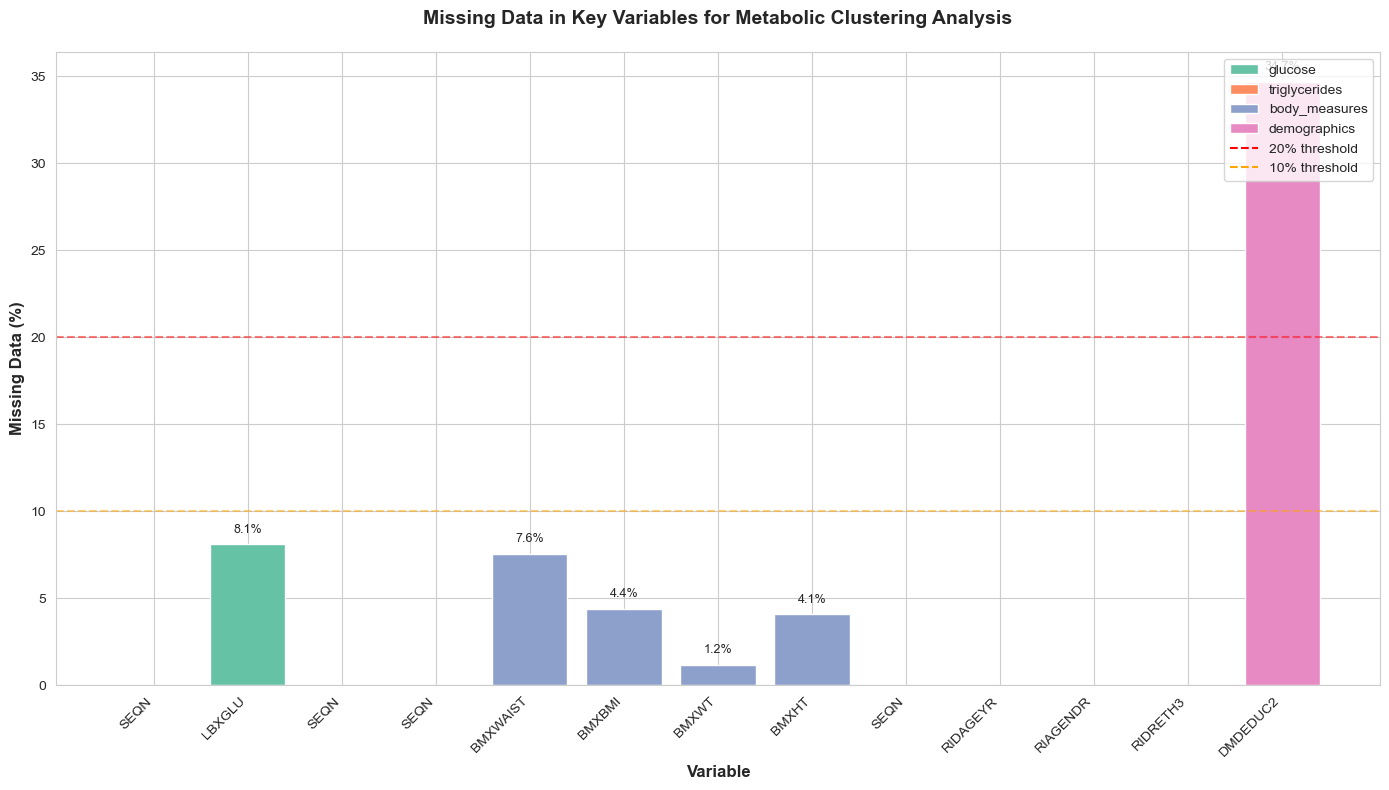


✓ figure saved to: results/figures/key_variables_missingness.png


In [9]:
# focus on key variables only
key_var_missing = {}

for dataset_name, vars_list in key_vars.items():
    df = data[dataset_name]
    
    # calculate missingness for key vars only
    missing_data = []
    for var in vars_list:
        if var in df.columns:
            missing_pct = (df[var].isnull().sum() / len(df)) * 100
            missing_data.append({
                'dataset': dataset_name,
                'variable': var,
                'missing_percent': missing_pct
            })
    
    key_var_missing[dataset_name] = pd.DataFrame(missing_data)

#combine all key variable missingness
all_key_missing = pd.concat(key_var_missing.values(), ignore_index=True)

#create visualization
fig, ax = plt.subplots(figsize=(14, 8))

#group by dataset for color coding
datasets = all_key_missing['dataset'].unique()
colors = sns.color_palette("Set2", len(datasets))
dataset_colors = dict(zip(datasets, colors))

#create grouped bar plot
x_pos = np.arange(len(all_key_missing))
bars = ax.bar(x_pos, all_key_missing['missing_percent'], 
               color=[dataset_colors[d] for d in all_key_missing['dataset']])

#customize plot
ax.set_xlabel('Variable', fontsize=12, fontweight='bold')
ax.set_ylabel('Missing Data (%)', fontsize=12, fontweight='bold')
ax.set_title('Missing Data in Key Variables for Metabolic Clustering Analysis', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(all_key_missing['variable'], rotation=45, ha='right')
ax.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
ax.axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='10% threshold')

#sdd value labels on bars and label
for i, (idx, row) in enumerate(all_key_missing.iterrows()):
    if row['missing_percent'] > 0:
        ax.text(i, row['missing_percent'] + 0.5, f"{row['missing_percent']:.1f}%", 
                ha='center', va='bottom', fontsize=9)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=dataset_colors[d], label=d) for d in datasets]
legend_elements.extend([
    plt.Line2D([0], [0], color='red', linestyle='--', label='20% threshold'),
    plt.Line2D([0], [0], color='orange', linestyle='--', label='10% threshold')
])
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('../../results/figures/key_variables_missingness.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n figure saved to: results/figures/key_variables_missingness.png")

In [12]:
#analyze how many participants have coplete data across all key variables (todetermine final sample size)

# merge all datasets on SEQN to check overlap
merged_ids = data['demographics'][['SEQN']].copy()

for dataset_name in ['glucose', 'triglycerides', 'body_measures']:
    dataset_ids = data[dataset_name][['SEQN']].copy()
    merged_ids = merged_ids.merge(dataset_ids, on='SEQN', how='inner', 
                                   suffixes=('', f'_{dataset_name}'))


print("participants overlap analysis")
print(f"Total participants in demographics:  {len(data['demographics']):>6,}")
print(f"Participants in glucose dataset:     {len(data['glucose']):>6,}")
print(f"Participants in triglycerides:       {len(data['triglycerides']):>6,}")
print(f"Participants in body measures:       {len(data['body_measures']):>6,}")
print(f"\nParticipants with all 4 datasets:    {len(merged_ids):>6,}")

# build complete merged dataset with correct variable names
merged_complete = data['demographics'][['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2']].copy()

# merge glucose data
merged_complete = merged_complete.merge(
    data['glucose'][['SEQN', 'LBXGLU', 'WTSAF2YR']], 
    on='SEQN', 
    how='left'
)

# emrge triglycerides data (note: LBXTLG not LBDTRIG)
merged_complete = merged_complete.merge(
    data['triglycerides'][['SEQN', 'LBXTLG']], 
    on='SEQN', 
    how='left'
)

# merge body measures
merged_complete = merged_complete.merge(
    data['body_measures'][['SEQN', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXHT']], 
    on='SEQN', 
    how='left'
)

print("\n")
print("MERGED DATASET SUMMARY")

print(f"Total participants after merge: {len(merged_complete):>6,}")
print(f"Variables in merged dataset:    {len(merged_complete.columns):>6}")
print(f"\nColumns: {list(merged_complete.columns)}")

# check completeness for core clustering variables
core_vars = ['LBXGLU', 'LBXTLG', 'BMXWAIST']
complete_core = merged_complete[core_vars].notna().all(axis=1)

print("\n core variables completeness")
print(f"Core variables for clustering: {core_vars}")
print(f"\nParticipants with complete core variables:")
print(f"  Complete:    {complete_core.sum():>6,} ({complete_core.sum()/len(merged_complete)*100:.1f}%)")
print(f"  Incomplete:  {(~complete_core).sum():>6,} ({(~complete_core).sum()/len(merged_complete)*100:.1f}%)")

# analyze patterns of missingness
print("\nMissingness by variable:")
for var in core_vars:
    n_missing = merged_complete[var].isna().sum()
    pct_missing = (n_missing / len(merged_complete)) * 100
    print(f"  {var:12s}: {n_missing:>6,} missing ({pct_missing:>5.1f}%)")

print("\n fasting status note")
print(" NHANES  Change:")
print("   • Fasting hours variable (PHAFSTHR) not available in lab files")
print("   • All participants in GLU_L and TRIGLY_L files are from")
print("     the morning fasting subsample (examined 8:30-11:30 AM)")
print("   • No additional fasting filter needed")
print("   • Source: NHANES 2021-2023 Lab Methods documentation")

# age filtering
adults_18plus = merged_complete['RIDAGEYR'] >= 18
print("\n age filtering")
print(f"Participants aged 18+:  {adults_18plus.sum():>6,} ({adults_18plus.sum()/len(merged_complete)*100:.1f}%)")
print(f"Participants under 18:  {(~adults_18plus).sum():>6,} ({(~adults_18plus).sum()/len(merged_complete)*100:.1f}%)")

# final eligible sample
eligible = complete_core & adults_18plus

print("\n final eligible sample swipe")
print(f"Criteria:")
print(f"  1. Complete glucose (LBXGLU)")
print(f"  2. Complete triglycerides (LBXTLG)")
print(f"  3. Complete waist circumference (BMXWAIST)")
print(f"  4. Age ≥ 18 years")
print(f"  5. Fasting status: All included (from fasting subsample)")
print(f"\nEligible participants: {eligible.sum():>6,} ({eligible.sum()/len(data['demographics'])*100:.1f}% of total)")

# store for laterr
n_total = len(data['demographics'])
n_in_all = len(merged_ids)
n_complete_core = complete_core.sum()
n_eligible = eligible.sum()

participants overlap analysis
Total participants in demographics:  11,933
Participants in glucose dataset:      3,996
Participants in triglycerides:        3,996
Participants in body measures:        8,860

Participants with all 4 datasets:     3,996


MERGED DATASET SUMMARY
Total participants after merge: 11,933
Variables in merged dataset:        12

Columns: ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'LBXGLU', 'WTSAF2YR', 'LBXTLG', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXHT']

 core variables completeness
Core variables for clustering: ['LBXGLU', 'LBXTLG', 'BMXWAIST']

Participants with complete core variables:
  Complete:     3,362 (28.2%)
  Incomplete:   8,571 (71.8%)

Missingness by variable:
  LBXGLU      :  8,261 missing ( 69.2%)
  LBXTLG      :  8,416 missing ( 70.5%)
  BMXWAIST    :  3,743 missing ( 31.4%)

 fasting status note
 NHANES  Change:
   • Fasting hours variable (PHAFSTHR) not available in lab files
   • All participants in GLU_L and TRIGLY_L files are from

C:\Users\cherr\AppData\Local\Temp\ipykernel_22828\1727063528.py:60: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.tight_layout()
C:\Users\cherr\AppData\Local\Temp\ipykernel_22828\1727063528.py:61: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig('../../results/figures/sample_selection_flowchart.png', dpi=300, bbox_inches='tight')
C:\Users\cherr\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


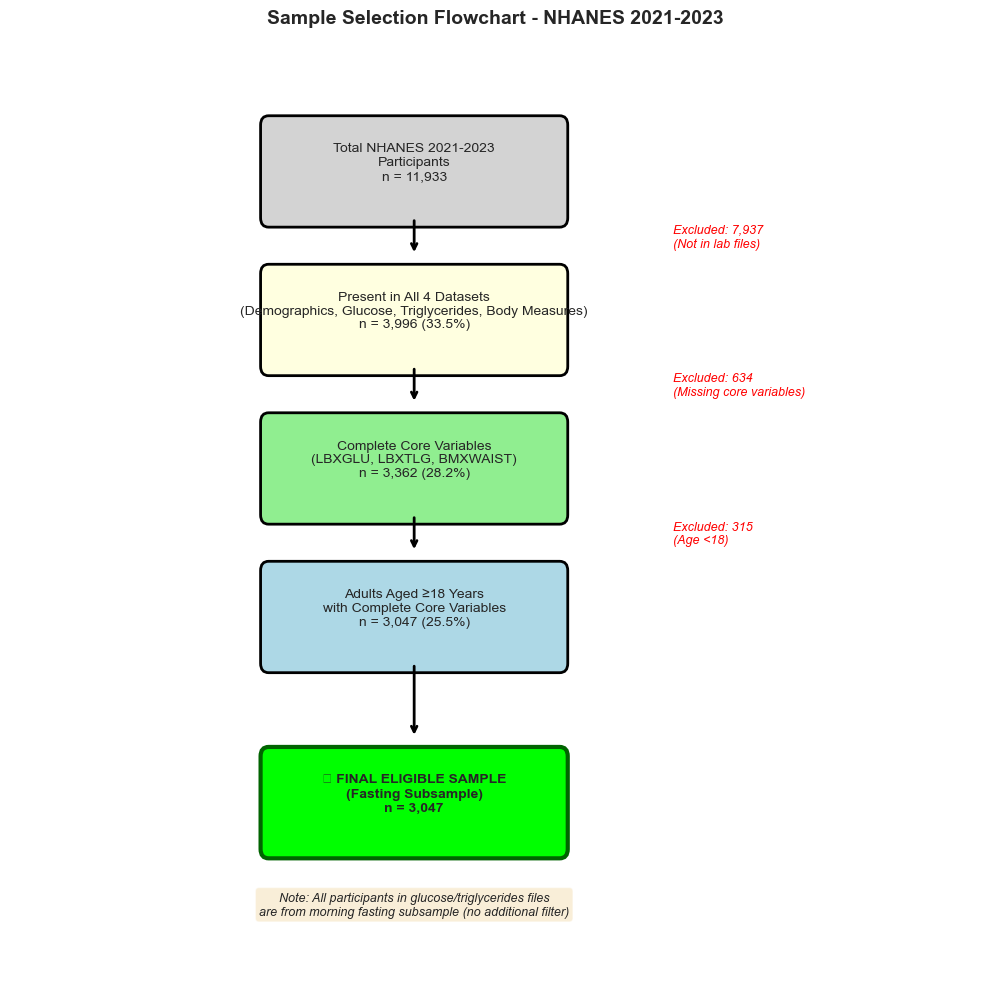


 Figure saved to: results/figures/sample_selection_flowchart.png


In [13]:
# create a flowchart style visualization
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# cefine box positions
boxes = [
    (0.5, 0.88, f"Total NHANES 2021-2023\nParticipants\nn = {n_total:,}"),
    (0.5, 0.72, f"Present in All 4 Datasets\n(Demographics, Glucose, Triglycerides, Body Measures)\nn = {n_in_all:,} ({n_in_all/n_total*100:.1f}%)"),
    (0.5, 0.56, f"Complete Core Variables\n(LBXGLU, LBXTLG, BMXWAIST)\nn = {n_complete_core:,} ({n_complete_core/n_total*100:.1f}%)"),
    (0.5, 0.40, f"Adults Aged ≥18 Years\nwith Complete Core Variables\nn = {n_eligible:,} ({n_eligible/n_total*100:.1f}%)"),
    (0.5, 0.20, f"✓ FINAL ELIGIBLE SAMPLE\n(Fasting Subsample)\nn = {n_eligible:,}"),
]

# draw boxes and arrows
colors = ['lightgray', 'lightyellow', 'lightgreen', 'lightblue', 'lime']
for i, (x, y, text) in enumerate(boxes):
    if i < len(boxes) - 1:
        box = mpatches.FancyBboxPatch((x-0.18, y-0.06), 0.36, 0.10,
                                       boxstyle="round,pad=0.01", 
                                       edgecolor='black', facecolor=colors[i],
                                       linewidth=2)
    else:
        box = mpatches.FancyBboxPatch((x-0.18, y-0.06), 0.36, 0.10,
                                       boxstyle="round,pad=0.01", 
                                       edgecolor='darkgreen', facecolor=colors[i],
                                       linewidth=3)
    ax.add_patch(box)
    
    fontweight = 'bold' if i == len(boxes)-1 else 'normal'
    ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight=fontweight)

arrow_props = dict(arrowstyle='->', lw=2, color='black')
for i in range(len(boxes)-1):
    ax.annotate('', xy=(boxes[i+1][0], boxes[i+1][1]+0.06), 
                xytext=(boxes[i][0], boxes[i][1]-0.06),
                arrowprops=arrow_props)

exclusions = [
    (0.82, 0.80, f"Excluded: {n_total - n_in_all:,}\n(Not in lab files)"),
    (0.82, 0.64, f"Excluded: {n_in_all - n_complete_core:,}\n(Missing core variables)"),
    (0.82, 0.48, f"Excluded: {n_complete_core - n_eligible:,}\n(Age <18)"),
]

for x, y, text in exclusions:
    ax.text(x, y, text, ha='left', va='center', fontsize=9, 
            style='italic', color='red')

note_text = ("Note: All participants in glucose/triglycerides files\n"
             "are from morning fasting subsample (no additional filter)")
ax.text(0.5, 0.08, note_text, ha='center', va='center', fontsize=9,
        style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1)
ax.set_title('Sample Selection Flowchart - NHANES 2021-2023', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../../results/figures/sample_selection_flowchart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to: results/figures/sample_selection_flowchart.png")

In [15]:
# Safety check - create summary_df if it doesn't exist
if 'summary_df' not in locals():
    print("⚠️ Warning: summary_df not found. Creating it now...")
    
    # Create comprehensive summary table with correct variable names
    summary_data = []
    
    key_variables_actual = {
        'glucose': ['SEQN', 'LBXGLU', 'LBDGLUSI', 'WTSAF2YR'],
        'triglycerides': ['SEQN', 'LBXTLG', 'LBDTRSI', 'WTSAF2YR'],
        'body_measures': ['SEQN', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXHT'],
        'demographics': ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2']
    }
    
    for dataset_name, vars_list in key_variables_actual.items():
        df = data[dataset_name]
        
        for var in vars_list:
            if var in df.columns:
                missing_count = df[var].isnull().sum()
                missing_pct = (missing_count / len(df)) * 100
                
                summary_data.append({
                    'Dataset': dataset_name,
                    'Variable': var,
                    'Total_N': len(df),
                    'Missing_N': missing_count,
                    'Missing_Pct': missing_pct,
                    'Complete_N': len(df) - missing_count,
                    'Complete_Pct': 100 - missing_pct
                })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df['Is_Core_Variable'] = summary_df['Variable'].isin(['LBXGLU', 'LBXTLG', 'BMXWAIST'])

print("Missing data analysis: key findings & recommendations")

# Calculate key metrics
total_participants = len(data['demographics'])
eligible_sample = n_eligible
retention_rate = (eligible_sample / total_participants) * 100

print(f"\n sample size projection:")
print(f"   - Starting population:        {total_participants:>7,} participants")
print(f"   - In fasting subsample:       {len(data['glucose']):>7,} participants")
print(f"   - Estimated eligible sample:  {eligible_sample:>7,} participants")
print(f"   - Retention rate:             {retention_rate:>7.1f}%")

print(f"\n key variable quality:")
core_summary = summary_df[summary_df['Variable'].isin(['LBXGLU', 'LBXTLG', 'BMXWAIST'])]
for _, row in core_summary.iterrows():
    print(f"   • {row['Variable']:12s}: {row['Missing_Pct']:.1f}% missing ({row['Complete_N']:,} complete)")


print(f"\n recommendation for next steps:")
print(f"   1. Merge all 4 datasets on SEQN")
print(f"   2. Filter to adults aged ≥18 years")
print(f"   3. Exclude participants missing any core variable (complete case analysis)")
print(f"   4. NO fasting filter needed (all participants already fasted)")
print(f"   5. Expected final sample: ~{eligible_sample:,} participants")
print(f"   6. Document exclusions in preprocessing pipeline")

if eligible_sample < 500:
    print(f"\n WARNING: Sample size <500 may affect cluster stability")
    print(f"   Consider: Relaxing age criteria or using imputation")
elif eligible_sample < 1000:
    print(f"\n  CAUTION: Sample size <1000: validate clusters carefully")
    print(f"   Recommend: Bootstrapping validation and sensitivity analyses")
else:
    print(f"\n EXCELLENT: Sample size ≥1000 sufficient for robust clustering")
    print(f"   Proceed with confidence to clustering analysis")



⚠️ Warning: summary_df not found. Creating it now...
Missing data analysis: key findings & recommendations

 sample size projection:
   - Starting population:         11,933 participants
   - In fasting subsample:         3,996 participants
   - Estimated eligible sample:    3,047 participants
   - Retention rate:                25.5%

 key variable quality:
   • LBXGLU      : 8.1% missing (3,672 complete)
   • LBXTLG      : 12.0% missing (3,517 complete)
   • BMXWAIST    : 7.6% missing (8,190 complete)

 recommendation for next steps:
   1. Merge all 4 datasets on SEQN
   2. Filter to adults aged ≥18 years
   3. Exclude participants missing any core variable (complete case analysis)
   4. NO fasting filter needed (all participants already fasted)
   5. Expected final sample: ~3,047 participants
   6. Document exclusions in preprocessing pipeline

 EXCELLENT: Sample size ≥1000 sufficient for robust clustering
   Proceed with confidence to clustering analysis
